# Make templates and line plots

- For future reference, make calibrated plots of each lamp at each position, with notable lines labeled (like what is shared from APO
- Do a good fit with the lines, write the `.spec` template files for each lamp at each position (to be used in auto-identify applications)

In [1]:
# need notebook backend for interaction
#  use inline for turn-key plotting
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# file-handling stuff for user, options abound! I like Tables and Pandas DataFrames
import pandas as pd
from astropy.table import Table
from astropy import units as u
from glob import glob

import sys
sys.path.append('/Users/james/Dropbox/research_projects/pykosmos2')

import pykosmos2 as pk
pk.__version__

'0.3.2'

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':12})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
# should i make a bias template? It's a big file to store...
biaslist = glob('../data/bias*.fits')
bias = pk.biascombine(biaslist)
# bias.write('bias.fits')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [4]:
# an artificial trace
trace = np.ones(bias.shape[0]) + 1100 

In [5]:
# all the internal lamp lines I manually identified...
df = pd.read_csv('../templates/NeKrAr_lines.csv')
len(df)

295

In [6]:
Bl = glob('../data/*Blue*2.0*.fits')
Bm = glob('../data/*Blue*1.18*.fits')
Bh = glob('../data/*Blue*0.86*.fits')
Rl = glob('../data/*Red*2.0*.fits')
Rm = glob('../data/*Red*1.18*.fits')
Rh = glob('../data/*Red*0.86*.fits')

In [7]:
files = Bl+Bm+Bh+Rl+Rm+Rh
files

['../data/Ne_Blue_2.0-low.0020.fits',
 '../data/Kr_Blue_2.0-low.0021.fits',
 '../data/Ar_Blue_2.0-low.0022.fits',
 '../data/Ar_Blue_1.18-ctr.0023.fits',
 '../data/Ne_Blue_1.18-ctr.0025.fits',
 '../data/Kr_Blue_1.18-ctr.0024.fits',
 '../data/Ar_Blue_0.86-high.0028.fits',
 '../data/Ne_Blue_0.86-high.0026.fits',
 '../data/Kr_Blue_0.86-high.0027.fits',
 '../data/Ar_Red_2.0-low.0035.fits',
 '../data/Ne_Red_2.0-low.0037.fits',
 '../data/Kr_Red_2.0-low.0036.fits',
 '../data/Kr_Red_1.18-ctr.0033.fits',
 '../data/Ne_Red_1.18-ctr.0032.fits',
 '../data/Ar_Red_1.18-ctr.0034.fits',
 '../data/Ne_Red_0.86-high.0031.fits',
 '../data/Kr_Red_0.86-high.0030.fits',
 '../data/Ar_Red_0.86-high.0029.fits']

In [8]:
# pd.Series(files).str.split('_',expand=True)

Red 2.0-low


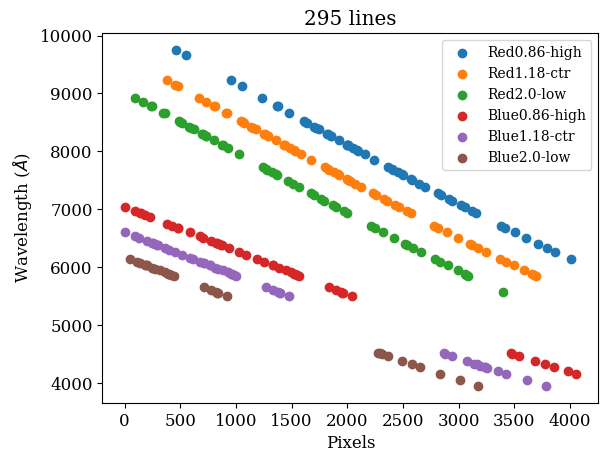

In [40]:
# 6 setups, plot them... 

# i=slit(low/med/hi), j=disp(red/blue)
i=2; j=0; k=0
print(df['disp'].unique()[j],df['slit'].unique()[i])

for j in range(2):
    for i in range(3):
        ll = (df['slit']==df['slit'].unique()[i]) & (df['disp']==df['disp'].unique()[j])
        plt.scatter(df['pixel'][ll], df['wave'][ll], label=df['disp'].unique()[j]+df['slit'].unique()[i])
plt.legend(fontsize=10)
plt.ylabel(r'Wavelength ($\AA$)')
plt.xlabel('Pixels')
plt.title(str(len(df['pixel']))+' lines')
plt.savefig('../figures/all_lines.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [31]:
# we need to iterate over the 6 (disp+slit), create a wavelenth solution
i=0; j=0 # DOUBLE FOR LOOP HERE
# i=slit(low/med/hi), j=disp(red/blue), cc=lamp(Neon/Ar/Kr)
for i in range(3):
    for j in range(2):

        print(df['disp'].unique()[j],df['slit'].unique()[i])

        ll = (df['slit']==df['slit'].unique()[i]) & (df['disp']==df['disp'].unique()[j])

        # read a random image first, just to make units work
        img_k = pk.proc(Rl[0], bias=bias, trim=False, Waxis=0)
        ex_k, _ = pk.BoxcarExtract(img_k, trace, apwidth=5, Waxis=0)

        tw = pk.fit_wavelength(ex_k, df['pixel'][ll].values, df['wave'][ll].values * u.angstrom, 
                                 display=False, mode='poly', deg=7, returnpoints=True)

        plt.figure()
        for cc in ['Neon', 'Ar', 'Kr']:
            plt.scatter(df['wave'][ll].values[df['lamp'][ll].values == cc], 
                        df['wave'][ll].values[df['lamp'][ll].values == cc] - tw[df['lamp'][ll].values == cc], 
                        label=cc, alpha=0.7)
        plt.xlabel(r'Wavelength ($\AA$)')
        plt.ylabel(r'Residuals ($\AA$)')
        plt.legend(fontsize=10)
        plt.ylim(-1,1)
        plt.title('Poly deg=7, '+df['disp'].unique()[j]+' '+df['slit'].unique()[i])
        plt.savefig('../figures/'+df['disp'].unique()[j]+df['slit'].unique()[i]+'_resid.png', 
                    dpi=150, bbox_inches='tight', pad_inches=0.25)
        plt.close()

        # now find the 3 lamps, apply wavelenth solution, save plots, save templates
        for cc in ['Ne', 'Ar', 'Kr']:
            for ff in files:
                if ((cc in ff) & (df['disp'].unique()[j] in ff) & (df['slit'].unique()[i] in ff)):
                    img_k = pk.proc(ff, bias=bias, trim=False, Waxis=0)
                    ex_k, _ = pk.BoxcarExtract(img_k, trace, apwidth=5, Waxis=0)

                    ex_fit = pk.fit_wavelength(ex_k, df['pixel'][ll].values, df['wave'][ll].values * u.angstrom, 
                                             display=False, mode='poly', deg=7)
#                     plt.figure(figsize=(12,6))
#                     plt.plot(ex_fit.spectral_axis, ex_fit.flux, c='k')
#                     plt.xlabel(r'Wavelength ($\AA$)')
#                     plt.ylabel('Flux ('+str(img_k.header['EXPTIME'])+' s)')
#                     plt.title(cc+' '+df['disp'].unique()[j]+' '+df['slit'].unique()[i])
#                     plt.savefig('../figures/'+cc+df['disp'].unique()[j]+df['slit'].unique()[i]+'_wave.png', 
#                                 dpi=150, bbox_inches='tight', pad_inches=0.25)
#                     plt.close()

                    plt.figure(figsize=(12,6))
                    plt.plot(ex_k.spectral_axis, ex_fit.flux, c='C0')
                    
                    ee = (df['slit']==df['slit'].unique()[i]) & (df['disp']==df['disp'].unique()[j]) & (df['lamp'].str[0:2]==cc)

                    plt.vlines(df['pixel'][ee], 1.05*np.max(ex_fit.flux.value),1.1*np.max(ex_fit.flux.value)
                               ,color='r', lw=0.6, alpha=0.75)
                    for tt in range(sum(ee)):
                        peak = 1.05*np.max(ex_fit.flux.value[np.abs(ex_k.spectral_axis.value - df['pixel'].values[ee][tt]) < 1])
                        plt.text(df['pixel'].values[ee][tt], peak, str(df['wave'].values[ee][tt]), 
                                 fontsize=8, rotation='vertical', color='k')
                    
                    plt.xlabel('Pixel')
                    plt.ylabel('Flux ('+str(img_k.header['EXPTIME'])+' s)')
                    plt.title(cc+' '+df['disp'].unique()[j]+' '+df['slit'].unique()[i])
                    plt.savefig('../figures/'+cc+df['disp'].unique()[j]+df['slit'].unique()[i]+'_pixel.pdf', 
                                dpi=150, bbox_inches='tight', pad_inches=0.25)
                    plt.close()

                    # using 7th deg poly this time, no uncertainties :(
                    sout = pd.DataFrame(data={'wave':ex_fit.spectral_axis.value,
                                              'flux':ex_fit.flux.value})

                    sout.to_csv('../templates/'+cc+df['disp'].unique()[j]+df['slit'].unique()[i]+'.spec', 
                                index=False, index_label=False)


Red 0.86-high


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Blue 0.86-high


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/james/Dropbox/research_projects/pykosmos2/pykosmos2/apextract.py:335: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/james/Dropbox/research_projects/pykosmos2/pykosmos2/apextract.py:335: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +


Red 1.18-ctr


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Blue 1.18-ctr


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/james/Dropbox/research_projects/pykosmos2/pykosmos2/apextract.py:335: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/james/Dropbox/research_projects/pykosmos2/pykosmos2/apextract.py:335: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +


Red 2.0-low


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Blue 2.0-low


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/james/Dropbox/research_projects/pykosmos2/pykosmos2/apextract.py:335: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/james/Dropbox/research_projects/pykosmos2/pykosmos2/apextract.py:335: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +


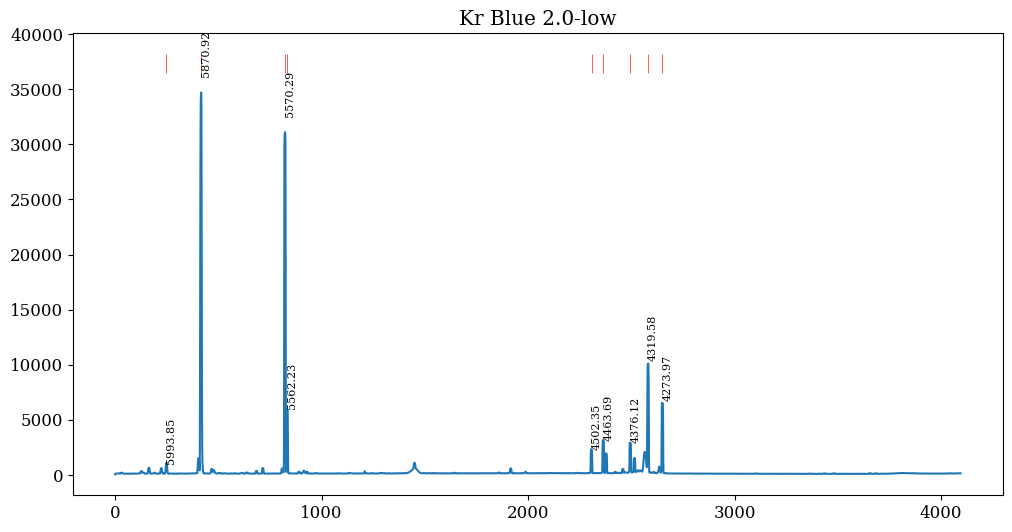

In [11]:
plt.figure(figsize=(12,6))
plt.plot(ex_k.spectral_axis, ex_fit.flux, c='C0')
plt.title(cc+' '+df['disp'].unique()[j]+' '+df['slit'].unique()[i])
ee = (df['slit']==df['slit'].unique()[i]) & (df['disp']==df['disp'].unique()[j]) & (df['lamp'].str[0:2]==cc)

plt.vlines(df['pixel'][ee], 1.05*np.max(ex_fit.flux.value),1.1*np.max(ex_fit.flux.value)
           ,color='r', lw=0.6, alpha=0.75)
for tt in range(sum(ee)):
    peak = 1.05*np.max(ex_fit.flux.value[np.abs(ex_k.spectral_axis.value - df['pixel'].values[ee][tt]) < 1])
    plt.text(df['pixel'].values[ee][tt], peak, str(df['wave'].values[ee][tt]), 
             fontsize=8, rotation='vertical', color='k')

In [12]:
# ALL THESE TEMPLATES NOW NEED TO SEAMLESSLY GO INTO DTW_IDENTIFY... AND WE NEED TO TEST IT!
# RELEASE THE NEXT VERSION OF PYKOSMOS ON PIP W/ FIXES FROM THIS & ANYTHING ELSE FOUND FROM FINISHING DTW

In [13]:
# anything else we need right now?


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/james/Dropbox/research_projects/pykosmos2/pykosmos2/apextract.py:335: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/james/Dropbox/research_projects/pykosmos2/pykosmos2/apextract.py:335: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +


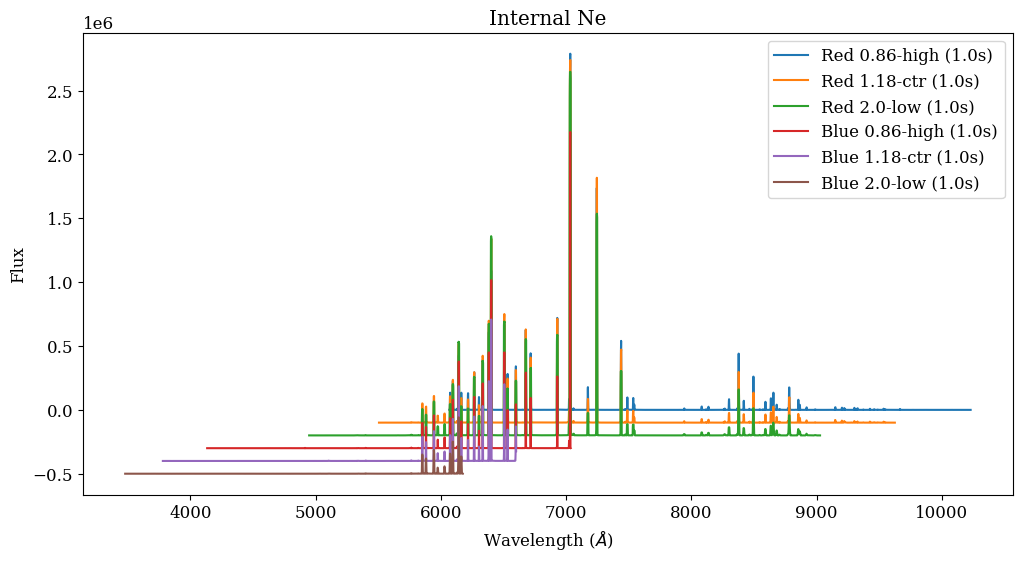

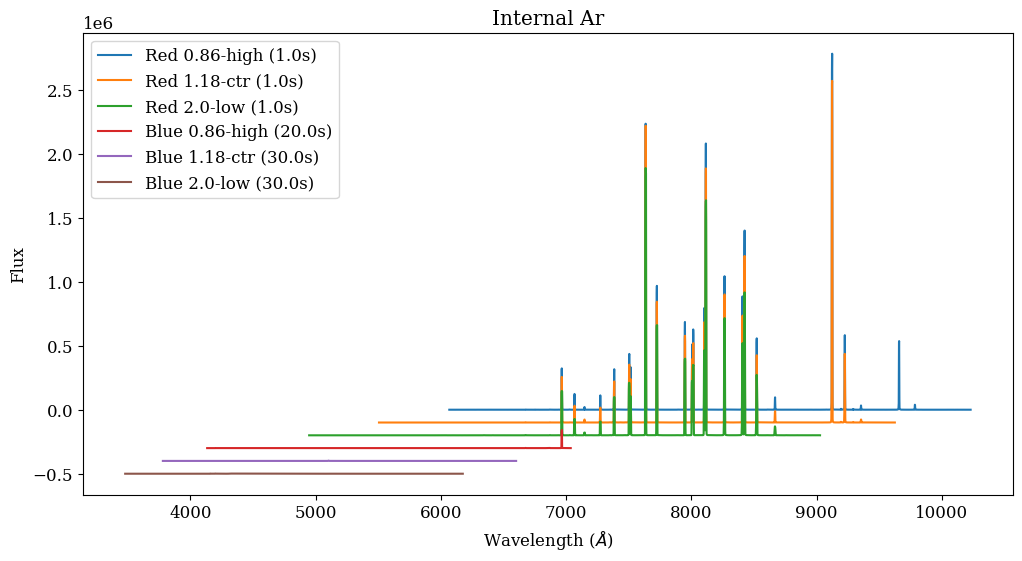

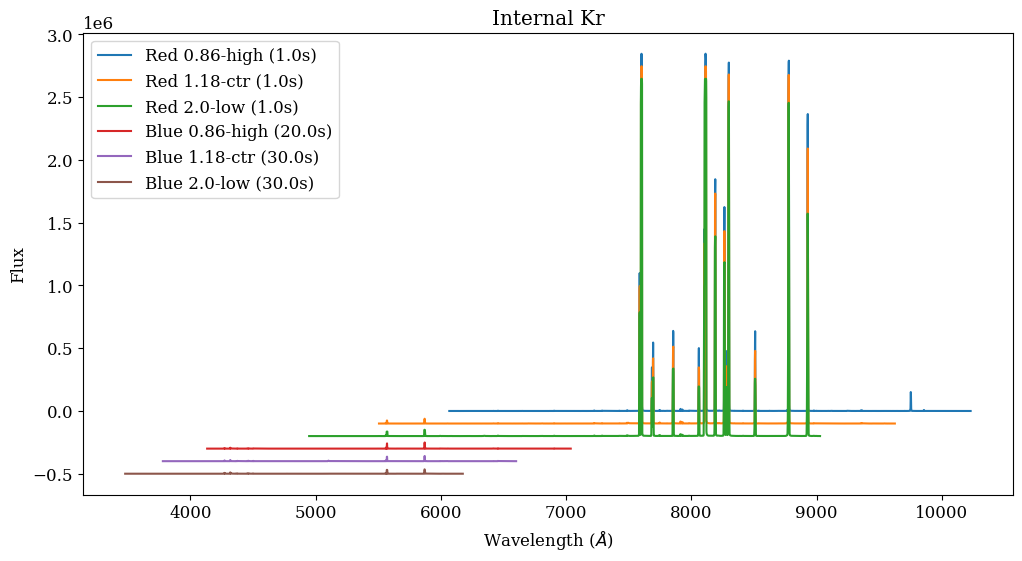

In [38]:
# make stacks for each lamp
for cc in ['Ne', 'Ar', 'Kr']:
    # we need to iterate over the 6 (disp+slit)
    plt.figure(figsize=(12,6))
    yoff = 0
    for j in range(2):
        for i in range(3):
            ll = (df['slit']==df['slit'].unique()[i]) & (df['disp']==df['disp'].unique()[j])

            for ff in files:
                if ((cc in ff) & (df['disp'].unique()[j] in ff) & (df['slit'].unique()[i] in ff)):
                    img_k = pk.proc(ff, bias=bias, trim=False, Waxis=0)
                    ex_k, _ = pk.BoxcarExtract(img_k, trace, apwidth=5, Waxis=0)

                    ex_fit = pk.fit_wavelength(ex_k, df['pixel'][ll].values, df['wave'][ll].values * u.angstrom, 
                                             display=False, mode='poly', deg=7)
                    
                    plt.plot(ex_fit.spectral_axis, ex_fit.flux.value - yoff, 
                             label=(df['disp'].unique()[j]+' '+
                                    df['slit'].unique()[i]+' ('+str(img_k.header['EXPTIME'])+'s)'))
                    
                    yoff = yoff + 100000
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Internal '+cc)
    plt.legend()
    plt.savefig('../figures/'+cc+'_stack.pdf', 
                dpi=150, bbox_inches='tight', pad_inches=0.25)


0 0 Red 0.86-high
0 1 Blue 0.86-high


LinAlgError: 2-th leading minor of the array is not positive definite

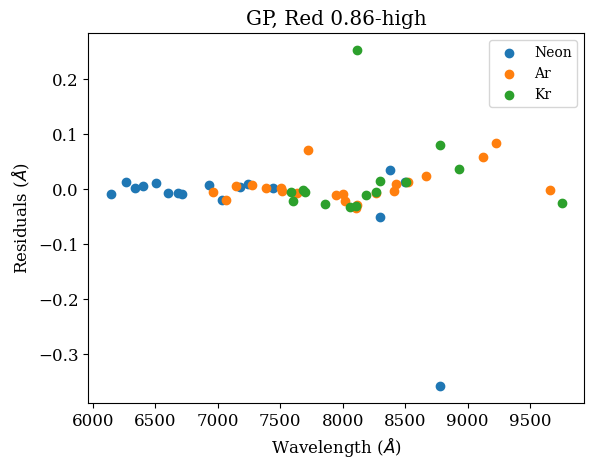

In [30]:
# could just TRY the GP... too much tuning. I'll come back someday and do this better

i=0; j=0 # DOUBLE FOR LOOP HERE
# i=slit(low/med/hi), j=disp(red/blue), cc=lamp(Neon/Ar/Kr)
for i in range(3):
    for j in range(2):

        print(i,j,df['disp'].unique()[j],df['slit'].unique()[i])

        ll = (df['slit']==df['slit'].unique()[i]) & (df['disp']==df['disp'].unique()[j])

        # read a random image first, just to make units work
        img_k = pk.proc(Rl[0], bias=bias, trim=False, Waxis=0)
        ex_k, _ = pk.BoxcarExtract(img_k, trace, apwidth=5, Waxis=0)

        tw = pk.fit_wavelength(ex_k, df['pixel'][ll].values, df['wave'][ll].values * u.angstrom, 
                                 display=False, mode='gp', xerror=0.1, GPRscale=1, returnpoints=True)

        plt.figure()
        for cc in ['Neon', 'Ar', 'Kr']:
            plt.scatter(df['wave'][ll].values[df['lamp'][ll].values == cc], 
                        df['wave'][ll].values[df['lamp'][ll].values == cc] - tw[df['lamp'][ll].values == cc], 
                        label=cc)
        plt.xlabel(r'Wavelength ($\AA$)')
        plt.ylabel(r'Residuals ($\AA$)')
        plt.legend(fontsize=10)
        plt.title('GP, '+df['disp'].unique()[j]+' '+df['slit'].unique()[i])
        plt.savefig('../figures/GP'+df['disp'].unique()[j]+df['slit'].unique()[i]+'_resid.png', 
                    dpi=150, bbox_inches='tight', pad_inches=0.25)

